In [1]:
import jax
import jax.lax as lax
import jax.numpy as jnp
from jax.random import key, split, uniform

import matplotlib.pyplot as plt


jax.config.update("jax_enable_x64", True)
# jnp.set_printoptions(precision=3)

In [23]:
n = 4 # Number of states
m = 3 # Number of observations
seed = 0

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.95 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.05 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(-jnp.linspace(0, 10, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jnp.zeros((n, m), dtype=jnp.float64)
O = O * jnp.linspace(0, 1, n)[:, None]
O = O.at[0, 0].set(1.0)
for s in range(n):
    O = O.at[s].set(jnp.exp(- ((jnp.arange(m) - (s*m) / n)**2)/(s + 1)))
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

# T = jax.random.uniform(key(0), (n,n))
# T = T / jnp.sum(T, axis=-1)[:,None]
print('T_TEST = jnp.array([\n\t' + ',\n\t'.join([ str([float(v) for v in row]) for row in T]) + '\n])')

# mu = jax.random.uniform(key(1), (n)) # key(5) for DIFFERENT_MU
# mu = mu / jnp.sum(mu)
print('MU_TEST_DIFFERENT = jnp.array([' + ', '.join([str(float(v)) for v in mu]) + '])')

# O = jax.random.uniform(key(2), (n,m))
# O = O / jnp.sum(O, axis=-1)[:,None]
print('O_TEST = jnp.array([\n\t' + ',\n\t'.join([ str([float(v) for v in row]) for row in O]) + '\n])')

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T_TEST = jnp.array([
	[0.95, 0.05, 0.0, 0.0],
	[0.0, 0.95, 0.05, 0.0],
	[0.0, 0.0, 0.95, 0.05],
	[0.0, 0.0, 0.0, 1.0]
])
MU_TEST_DIFFERENT = jnp.array([0.964369788973432, 0.03440292143612942, 0.001227289590438528, 0.0])
O_TEST = jnp.array([
	[0.7213991842739687, 0.2653879287722419, 0.013212886953789416],
	[0.3459541948223698, 0.44421397916166544, 0.20983182601596484],
	[0.2042705586529167, 0.39786472067354167, 0.39786472067354167],
	[0.0, 0.0, 1.0]
])
T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


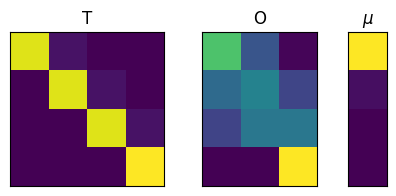

In [24]:
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(5,2)
ax[0].imshow(T)
ax[0].set_title("T")
ax[1].imshow(O)
ax[1].set_title("O")
ax[2].imshow(mu[:,None])
ax[2].set_title(r"$\mu$")
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

In [25]:
from baum_welch_jax.algorithms import generate_sequence
from baum_welch_jax.models import HiddenMarkovParameters

n_sequences = 2_000_000
len_sequence = 7
rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, HiddenMarkovParameters(T, O, mu), len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

print("states.shape =", states.shape)

states.shape = (2000000, 7)


In [35]:
from baum_welch_jax.algorithms import log_likelihood

sampled_llhood = 'TEST_LIKELIHOODS_STRUCTURED_6_STEPS = ['
final_state_distr = 'FINAL_STATE_DISTR_STRUCTURED_6_STEPS = [\n'
test_sequences = 'TEST_SEQUENCES_STRUCTURED_6_STEPS = [\n'

state_distr_list = []
cutoff = 5

for n_seq in (10321, 3, 0, 13434, 1234, 645233, 300000, 89300, 999000):
    test_seq = observations[n_seq, :cutoff]
    state_seq = states[n_seq, :cutoff]
    identical_indices = jnp.all(observations[:, :cutoff] == test_seq, axis=-1)
    identical_samples = jnp.sum(identical_indices)

    final_states = states[identical_indices, cutoff - 1]

    distribution = jnp.zeros(n)
    for k in range(n):
        distribution = distribution.at[k].set(jnp.sum(final_states == k))
    
    distribution = distribution / jnp.sum(distribution)

    sampled_likelihood = identical_samples / observations.shape[0]
    # log_state_distr, log_llhood = log_likelihood(test_seq, T, O, mu, return_stats=True)

    # display((test_seq, sampled_likelihood, jnp.exp(log_llhood[-1])))
    test_sequences += '\tjnp.array([' + ','.join([str(v) for v in test_seq]) + ']).astype(jnp.int32),\n'
    sampled_llhood += str(sampled_likelihood) + ', '
    final_state_distr += '\tjnp.array([' + ','.join([str(v) for v in distribution]) + ']),\n'

    identical_indices = jnp.all(observations[:, :cutoff] == test_seq[:cutoff], axis=-1)
    identical_samples = jnp.sum(identical_indices)

    filtered_states = states[identical_indices]

    state_distr = lax.map(lambda s: jnp.count_nonzero(filtered_states == s, axis=0), jnp.arange(n)) / filtered_states.shape[0]
    state_distr_list.append(state_distr)



sampled_llhood += ']'
final_state_distr += ']'
test_sequences += ']'

print(test_sequences)
print(sampled_llhood)
print(final_state_distr)



TEST_SEQUENCES_STRUCTURED_6_STEPS = [
	jnp.array([0,0,1,0,1]).astype(jnp.int32),
	jnp.array([0,0,1,1,1]).astype(jnp.int32),
	jnp.array([1,1,0,0,1]).astype(jnp.int32),
	jnp.array([1,1,0,1,0]).astype(jnp.int32),
	jnp.array([0,0,0,0,0]).astype(jnp.int32),
	jnp.array([0,0,0,0,0]).astype(jnp.int32),
	jnp.array([1,0,1,0,0]).astype(jnp.int32),
	jnp.array([0,0,1,2,1]).astype(jnp.int32),
	jnp.array([0,2,1,0,1]).astype(jnp.int32),
]
TEST_LIKELIHOODS_STRUCTURED_6_STEPS = [0.026176, 0.012832, 0.0096475, 0.0089175, 0.1608765, 0.1608765, 0.0225225, 0.0026465, 0.001081, ]
FINAL_STATE_DISTR_STRUCTURED_6_STEPS = [
	jnp.array([0.7972188264058679,0.19330684596577016,0.009474327628361858,0.0]),
	jnp.array([0.5939837905236908,0.37651963840399,0.029496571072319202,0.0]),
	jnp.array([0.811401917595232,0.17963202902306297,0.008966053381705105,0.0]),
	jnp.array([0.8543313708999158,0.1377067563779086,0.007961872722175498,0.0]),
	jnp.array([0.9545645262048839,0.0445932128060966,0.0008422609890195274,0.0]),
	jnp.

In [27]:
log_state_distr, log_llhood = log_likelihood(test_seq, HiddenMarkovParameters(T, O, mu), return_stats=True)
display((test_seq, sampled_likelihood, jnp.exp(log_llhood[-1])))
print(jnp.exp(log_state_distr))

(Array([0, 2, 1, 0, 1], dtype=int64),
 Array(0.001081, dtype=float64),
 Array(0.00109147, dtype=float64))

[3.80407754e-04 6.42549241e-04 6.85175336e-05 0.00000000e+00]


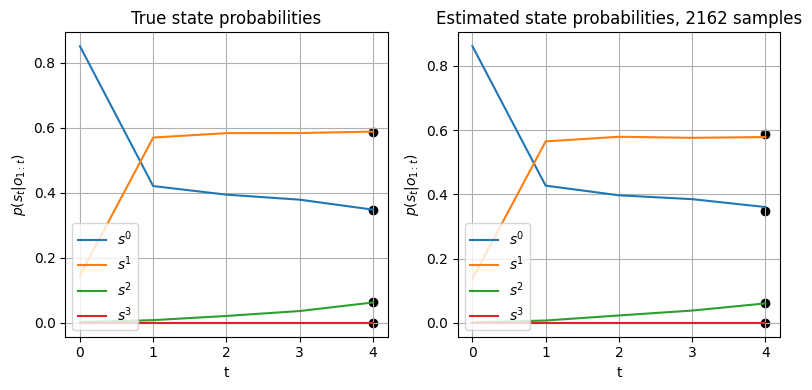

In [28]:
from jax.scipy.special import logsumexp
from baum_welch_jax.algorithms import forward_backward


gamma, xi = forward_backward(test_seq, HiddenMarkovParameters(T, O , mu), mode='regular')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8,4)

cutoff = 5

for k, row in enumerate((gamma / jnp.sum(gamma, axis=-1)[:, None]).T):
    ax[0].plot(row[:cutoff], label=f"$s^{k}$")
ax[0].set_title("True state probabilities")

for k, row in enumerate(state_distr):
    ax[1].plot(row[:cutoff], label=f"$s^{k}$")
ax[1].set_title("Estimated state probabilities" + f", {len(filtered_states)} samples")

for k in (0,1):
    ax[k].set_xlabel("t")
    ax[k].set_ylabel("$p(s_t | o_{1:t})$")
    ax[k].grid()
    ax[k].legend(loc="lower left")
    ax[k].scatter(jnp.ones(n) * (cutoff -1), jnp.exp(log_state_distr - logsumexp(log_state_distr)), color='black')

plt.tight_layout()
plt.show()

In [36]:
print('STATE_DISTR_STRUCTURED_6_STEPS = [')
cutoff = 6
for distr in state_distr_list:
    print('\tjnp.array(', [[float(v) for v in row[:cutoff]] for row in distr], '),')

print(']')

STATE_DISTR_STRUCTURED_6_STEPS = [
	jnp.array( [[0.9906593826405868, 0.9608992970660146, 0.9000611246943765, 0.8654301650366748, 0.7972188264058679, 0.758270935207824], [0.009283312958435208, 0.038890586797066015, 0.09862087408312958, 0.13059672982885084, 0.19330684596577016, 0.2232388447432763], [5.730440097799511e-05, 0.0002101161369193154, 0.0013180012224938875, 0.003973105134474328, 0.009474327628361858, 0.01812729217603912], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0003629278728606357]] ),
	jnp.array( [[0.9727634039900249, 0.8941708229426434, 0.7346477556109726, 0.6447163341645885, 0.5939837905236908, 0.5646041147132169], [0.02715866583541147, 0.1051278054862843, 0.26114401496259354, 0.3402041770573566, 0.37651963840399, 0.3870791770573566], [7.793017456359102e-05, 0.0007013715710723192, 0.004208229426433915, 0.015079488778054862, 0.029496571072319202, 0.04695293017456359], [0.0, 0.0, 0.0, 0.0, 0.0, 0.001363778054862843]] ),
	jnp.array( [[0.9636693443897383, 0.9355273386887795, 0.9174915781290

In [32]:
cutoff = 6

transition_tensors = []
for n_seq in (10321, 3, 0, 13434, 1234, 645233, 300000, 89300, 999000):
    test_seq = observations[n_seq, :cutoff]
    state_seq = states[n_seq, :cutoff]

    identical_indices = jnp.all(observations[:, :cutoff] == test_seq, axis=-1)
    identical_samples = jnp.sum(identical_indices)

    transition_probabilities = jnp.ones((cutoff - 1, n, n))
    for k in range(cutoff - 1):
        for i in range(n):
            for j in range(n):
                current = states[:, k] == i
                next_state = states[:, k +1] == j

                current_indices = identical_indices & current 
                transition_indices = current_indices & next_state

                transition_probabilities = transition_probabilities.at[k, i, j].set(jnp.sum(transition_indices) / jnp.sum(identical_indices))

    transition_tensors.append(transition_probabilities)


In [33]:
print('TRANSITION_TENSORS_STRUCTURED_TEST_6_STEPS = [')

output = ''
for tensor in transition_tensors:
    output += '\tjnp.array([\n'

    for matrix in tensor:
        output += '\t['
        for row in matrix:
            output += '\n\t\t[' + ', '.join([str(float(v)) for v in row]) + '], '
        output += '\n\t],\n'
    output += '\n\t]),\n'

print(output)
print(']')

TRANSITION_TENSORS_STRUCTURED_TEST_6_STEPS = [
	jnp.array([
	[
		[0.9788886192671682, 0.016106527541858772, 0.0, 0.0], 
		[0.0, 0.0048228585294831355, 9.099733074496482e-05, 0.0], 
		[0.0, 0.0, 9.099733074496482e-05, 0.0], 
		[0.0, 0.0, 0.0, 0.0], 
	],
	[
		[0.9463722397476341, 0.032516379519534094, 0.0, 0.0], 
		[0.0, 0.02068672652268867, 0.0002426595486532395, 0.0], 
		[0.0, 0.0, 0.00018199466148992964, 0.0], 
		[0.0, 0.0, 0.0, 0.0], 
	],
	[
		[0.9283244358165493, 0.01804780393108469, 0.0, 0.0], 
		[0.0, 0.05238413006551808, 0.0008189759767046834, 0.0], 
		[0.0, 0.0, 0.00042465421014316915, 0.0], 
		[0.0, 0.0, 0.0, 0.0], 
	],
	[
		[0.8910761950982771, 0.03724824071827226, 0.0, 0.0], 
		[0.0, 0.06903664159184664, 0.001395292404756127, 0.0], 
		[0.0, 0.0, 0.0012436301868478524, 0.0], 
		[0.0, 0.0, 0.0, 0.0], 
	],
	[
		[0.8690245086144139, 0.02205168648386314, 0.0, 0.0], 
		[0.0, 0.10309997573404514, 0.0031849065760737685, 0.0], 
		[0.0, 0.0, 0.0026389225916039795, 0.0], 
		[0.0, 0.0, 0

In [34]:
from baum_welch_jax.algorithms import forward_backward

_, xi = forward_backward(test_seq, HiddenMarkovParameters(T, O, mu), mode='regular')

print(len(test_seq), xi.shape, transition_tensors[-1].shape)
xi, transition_tensors[-1]

6 (5, 4, 4) (5, 4, 4)


(Array([[[0.5894613 , 0.30712802, 0.        , 0.        ],
         [0.        , 0.09983153, 0.00255615, 0.        ],
         [0.        , 0.        , 0.00102301, 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.57038293, 0.01907837, 0.        , 0.        ],
         [0.        , 0.40146406, 0.00549548, 0.        ],
         [0.        , 0.        , 0.00357916, 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.55915909, 0.01122384, 0.        , 0.        ],
         [0.        , 0.41411517, 0.00642726, 0.        ],
         [0.        , 0.        , 0.00907464, 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.53636983, 0.02278926, 0.        , 0.        ],
         [0.        , 0.41415873, 0.01118028, 0.        ],
         [0.        , 0.        , 0.0155019 , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.52316515, 0.01320469, 0.        